<a href="https://colab.research.google.com/github/Greta-gerasimov/Busina_ML/blob/3L_bus_ML/L3__ML_bus_metricsipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
import itertools

In [ ]:
df = pd.read_csv('train_case2.csv', sep=';')
df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


In [ ]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'),
                                                    df['cardio'], random_state=0)

Применяю к небинарным признакам: **one_hot**_кодирование;
вещественным признакам - нормализацию:**StandartScaler**;
все остальные - без изменений

In [ ]:

#pipeline №1 - конструктор для разных фичей
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
#pipeline №2 -OHEEncoder
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []


#pipeline №3 - standart scaler
for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))

for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))

for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [ ]:
#pipeline №4 - union

from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
#pipeline №5 - итоговый с логистической регрессией
model_logreg = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])


#cross_val


# запустим кросс-валидацию
cv_scores = cross_val_score(model_logreg , X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
model_logreg.fit(X_train, y_train)
y_score = model_logreg.predict_proba(X_test)[:, 1]



CV score is 0.7864573689384385+-0.004422021036885763


Основные метрики и порог, при котором они идеальны, с точки зрения DS

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3869370891147378, F-Score=0.730, Precision=0.647, Recall=0.838


Best Threshold=0.3869370891147378,

F-Score=0.730,

Precision=0.647,

 Recall=0.838

roc_auc кривая:



y:
**True Positive Rate**
Полнота (Sensitivity, Recall, Hit Rate, TPR) отражает какой процент объектов положительного класса мы правильно классифицировали;

x:
**False Positive Rate** (FPR, fall-out, false alarm rate) – доля объектов негативного класса, которых мы ошибочно отнесли к положительному





In [ ]:
roc_auc = roc_auc_score(y_test,  y_score)
roc_auc

0.7840347790421852

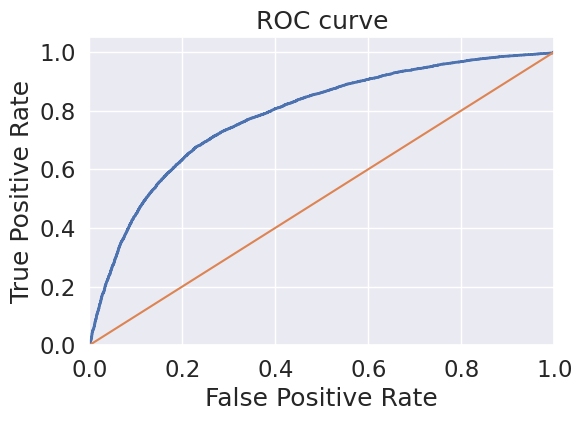

In [ ]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(6, 4))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

print(f"roc auc score: {roc_auc_score(y_train, model_logreg.predict_proba(X_train)[:, 1])}")

print(f"roc auc score: {roc_auc_score(y_test, model_logreg.predict_proba(X_test)[:, 1])}")

roc auc score: 0.7870081561637485
roc auc score: 0.7840347790421852


матрица ошибок

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


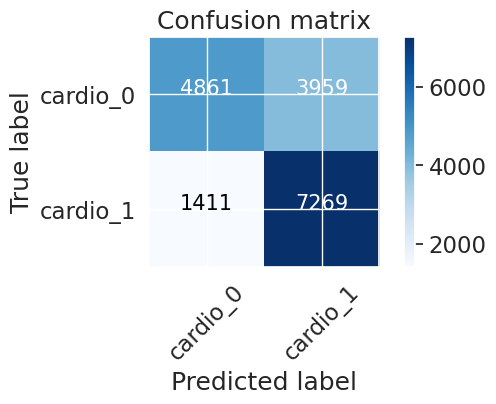

In [ ]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта


Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)


Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
стоимость лечения 15000р, если сделали тест и начали лечить вовремя
стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
стоимость теста 1400р

Сделать выводы о том, какая модель справилась с задачей лучше других
*Найти порог классификации по деньгам для лучшей модели
Стоимость лечения 15000р, если сделали тест и начали лечить вовремя
Стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
Стоимость теста 1400р

In [ ]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 152974200


In [ ]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

**Точность (Precision, Positive Predictive Value, PPV)** отражает какой процент положительных объектов (т.е. тех, что мы считаем положительными) правильно классифицирован

**Полнота (Sensitivity, True Positive Rate, Recall, Hit Rate, TPR)** отражает какой процент объектов положительного класса мы правильно классифицировали

**False Positive Rate (FPR, fall-out, false alarm rate)** – доля объектов негативного класса, которых мы ошибочно отнесли к положительному

**True Negative Rate (TNR)** - процент правильно классифицированных объектов негативного класса.

**False Positive Rate** довольно высокий ~ 0.45.

Это означает, что 45 процентов здоровых пациентов получат метку 1.

In [ ]:
fpr_1k, tpr_1k, thresholds_ = roc_curve(y_test, y_score, pos_label=1)

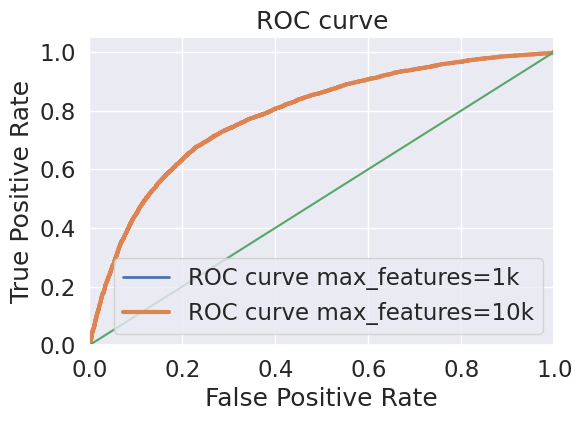

In [ ]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(6, 4))


fpr_10k, tpr_10k, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr_1k, tpr_1k, lw=lw, label='ROC curve max_features=1k')
plt.plot(fpr_10k, tpr_10k, lw=lw+1, label='ROC curve max_features=10k')

plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.legend()
plt.show()

In [ ]:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC', 'rubl_ML'])
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML


In [ ]:
metrics_df = metrics_df.append({
    'model': type(model_logreg['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc,
    'rubl_ML': rubl_ML
}, ignore_index=True)

metrics_df

<ipython-input-21-456c0d030621>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,152974200


**II.**

**RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)), # гиперпараметры по умолчанию
])

# обучим пайплайн на всем тренировочном датасете
model_rf.fit(X_train, y_train)

y_score = model_rf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.35, F-Score=0.719, Precision=0.643, Recall=0.816


In [ ]:
roc_auc = roc_auc_score(y_test, y_score)
roc_auc

0.7710366181802983

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 153699400


In [ ]:
TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.8084101382488479, 0.43412698412698414, 0.5658730158730159)

**False Positive Rate** ~ 0.43.

Это означает, что 43 процентов здоровых пациентов получат метку 1.

In [ ]:
fpr_1k, tpr_1k, thresholds_ = roc_curve(y_test, y_score, pos_label=1)

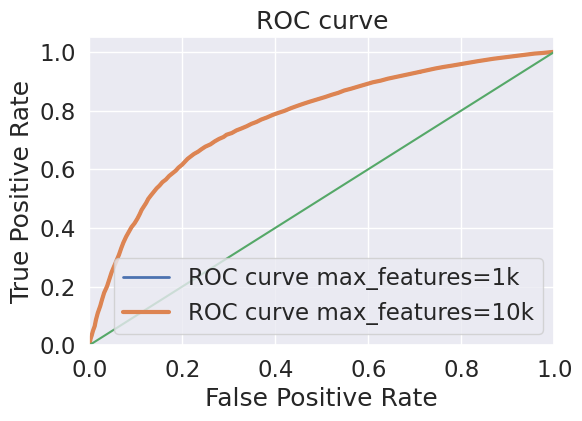

In [ ]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(6, 4))


fpr_10k, tpr_10k, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr_1k, tpr_1k, lw=lw, label='ROC curve max_features=1k')
plt.plot(fpr_10k, tpr_10k, lw=lw+1, label='ROC curve max_features=10k')

plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.legend()
plt.show()

In [ ]:
metrics_df = metrics_df.append({
    'model': type(model_rf['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc,
    'rubl_ML': rubl_ML
}, ignore_index=True)

metrics_df

<ipython-input-28-0690377a5244>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,152974200
1,RandomForestClassifier,0.350000,0.718863,0.642669,0.815553,0.771037,153699400


**III.**

**GradientBoostingClassifier**


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


model_gb = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=42)), # гиперпараметры по умолчанию
])

# обучим пайплайн на всем тренировочном датасете
model_gb.fit(X_train, y_train)

y_score = model_gb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_score)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.39494659702686624, F-Score=0.740, Precision=0.698, Recall=0.788


In [ ]:
roc_auc = roc_auc_score(y_test, y_score)
roc_auc

0.8026153641179974

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
print('расходы, если использовать МЛ:', rubl_ML)

расходы, если использовать МЛ: 153122800


In [ ]:
TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.7880184331797235, 0.33582766439909295, 0.664172335600907)

**False Positive Rate** ~ 0.33.

Это означает, что 33 процентов здоровых пациентов получат метку 1.

In [ ]:
fpr_1k, tpr_1k, thresholds_ = roc_curve(y_test, y_score, pos_label=1)

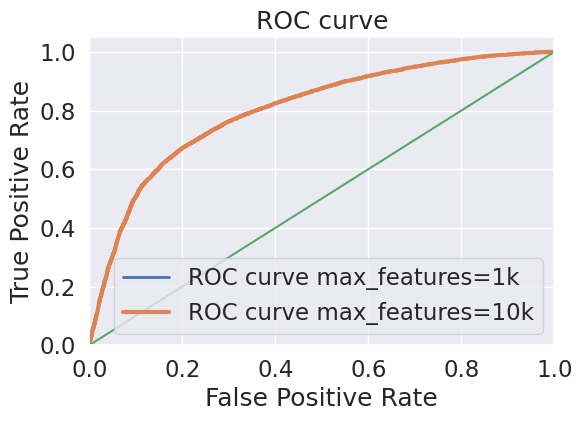

In [ ]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(6, 4))


fpr_10k, tpr_10k, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr_1k, tpr_1k, lw=lw, label='ROC curve max_features=1k')
plt.plot(fpr_10k, tpr_10k, lw=lw+1, label='ROC curve max_features=10k')

plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.legend()
plt.show()

In [ ]:
metrics_df = metrics_df.append({
    'model': type(model_gb['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc,
    'rubl_ML': rubl_ML
}, ignore_index=True)

metrics_df

<ipython-input-35-92e6b8f7e5eb>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,152974200
1,RandomForestClassifier,0.350000,0.718863,0.642669,0.815553,0.771037,153699400
2,GradientBoostingClassifier,0.394947,0.740248,0.697848,0.788134,0.802615,153122800


 минимальные расходы

In [ ]:
metrics_df.sort_values('rubl_ML')

,model,thresh,F-Score,Precision,Recall,ROC AUC,rubl_ML
0,LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035,152974200
2,GradientBoostingClassifier,0.394947,0.740248,0.697848,0.788134,0.802615,153122800
1,RandomForestClassifier,0.350000,0.718863,0.642669,0.815553,0.771037,153699400


*** Найти порог классификации по деньгам для лучшей модели

На мой взгляд, лучше всего справилась модель с градиентным спуском, но по деньгам, очевидно, что лидер рейтинга - логистическая регрессия. посчитаю пороги для обеих моделей




In [ ]:
def business_threshold_calibrate(y_test, y_score,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    rubl_ML_ = 1_000_000_000

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment

        if rubl_ML < rubl_ML_:
            business_threshold = opt_buisness_tr

            rubl_ML_ = rubl_ML

        rs.append(rubl_ML)


    print('расходы, если использовать МЛ:', rubl_ML_)

    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

gradient diecent

расходы, если использовать МЛ: 152333600


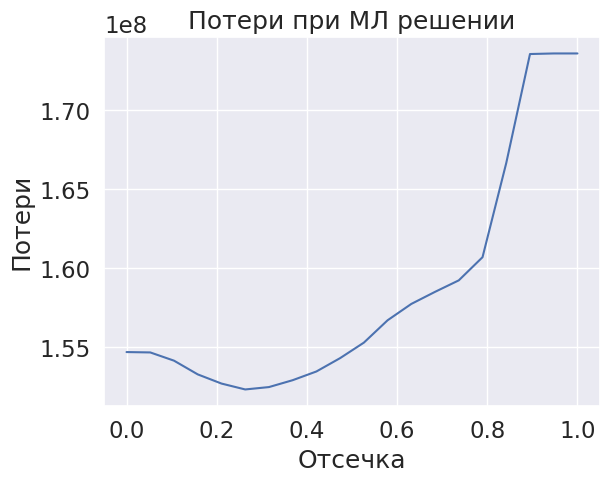

уровень порога по бизнес метрике 0.2631578947368421


In [ ]:
busines_tr = business_threshold_calibrate(y_test,
                                          model_gb.predict_proba(X_test)[:, 1],
                                          rubl_test=1400,
                                          rubl_early_treatment=15000,
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)

logreg

расходы, если использовать МЛ: 152712400


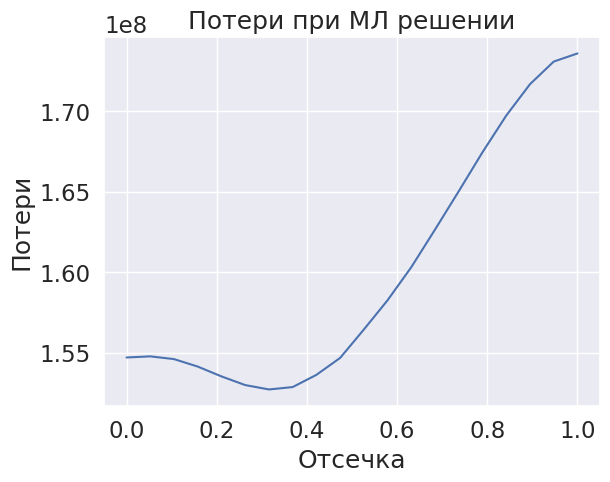

уровень порога по бизнес метрике 0.3157894736842105


In [ ]:
busines_tr = business_threshold_calibrate(y_test,
                                          model_logreg.predict_proba(X_test)[:, 1],
                                          rubl_test=1400,
                                          rubl_early_treatment=15000,
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)